In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_train=pd.read_csv('./datasets/titanic/train.csv')
data_test=pd.read_csv('./datasets/titanic/test_augmented.csv')
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [11]:
man_total=data_train[data_train.iloc[:,4]=='male']
man_survived=man_total[man_total.iloc[:,1] == 1]
survive_rate=man_survived.shape[0]/man_total.shape[0]
print(f'男性幸存数:{man_survived.shape[0]}\n男性幸存率:{round(survive_rate, 2)}')
female_total=data_train[data_train.iloc[:,4]=='female']
female_survived=female_total[female_total.iloc[:,1] == 1]
survive_rate=len(female_survived)/len(female_total)
print(f'女性幸存数:{female_survived.shape[0]}\n女性幸存率{round(survive_rate,2)}')

男性幸存数:109
男性幸存率:0.19
女性幸存数:233
女性幸存率0.74


In [12]:
data_train['age_group']=pd.cut(data_train.iloc[:,5],bins=[0,18,30,45,np.inf],labels=['未成年','青年','中年','老年'])
age_survive_rate=data_train[data_train.iloc[:,1]==1].groupby('age_group',observed=False).agg('count').iloc[:,0]/data_train['age_group'].value_counts()
data_train.info()
age_survive_rate

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    int64   
 3   Name         891 non-null    object  
 4   Sex          891 non-null    object  
 5   Age          714 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    object  
 9   Fare         891 non-null    float64 
 10  Cabin        204 non-null    object  
 11  Embarked     889 non-null    object  
 12  age_group    714 non-null    category
dtypes: category(1), float64(2), int64(5), object(5)
memory usage: 84.7+ KB


age_group
未成年    0.503597
青年     0.355556
中年     0.425743
老年     0.368932
dtype: float64

特征分析:对生存率无影响的特征:PassengerId,Name,SibSp,Parch,Ticket,Cabin,Embarked。所以X_train:Pclass,Sex,Age:y_train:Survived。
此外，直觉上仓位应该对生存率有正面影响所以头等舱的权重应该更大，所以Pclass数值上应该颠倒。

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Pclass  891 non-null    int64  
 1   Sex     891 non-null    object 
 2   Age     714 non-null    float64
 3   Fare    891 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 28.0+ KB


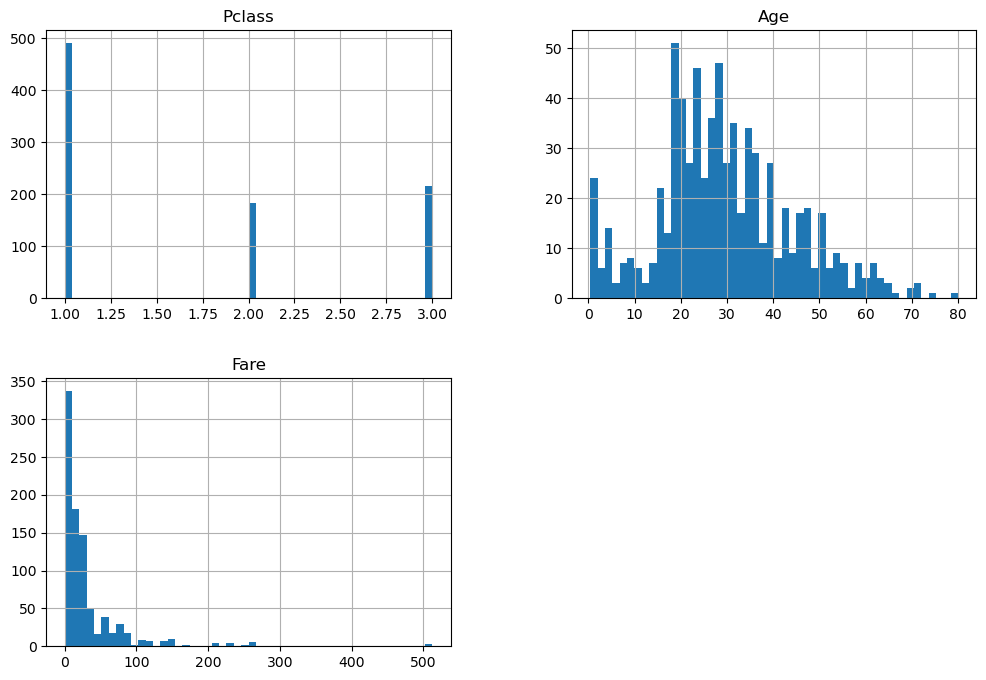

In [13]:
# 1
X_train=data_train.drop(['PassengerId','Name','SibSp','Parch','Ticket','Cabin','Embarked','Survived','age_group'],axis=1)
y_train=data_train['Survived']
X_test=data_test.drop(['PassengerId','Name','SibSp','Parch','Ticket','Cabin','Embarked','Survived'],axis=1)
y_test=data_test['Survived']
X_train['Pclass']=4-X_train['Pclass']
X_test['Pclass'] = 4 - X_test['Pclass']

X_train.info()
X_train.hist(bins=50, figsize=(12, 8))
plt.show()

In [14]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,FunctionTransformer
from sklearn.pipeline import Pipeline

numeric_features=['Pclass','Age','Fare']
cat_features=['Sex']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])


In [15]:
preprocessor = ColumnTransformer(
    transformers=[
        # 对Fare列应用对数转换和标准化
        ('fare', Pipeline(steps=[
            ('log', FunctionTransformer(np.log1p)),
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), ['Fare']),

        # 对Pclass和Age应用标准化
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), ['Pclass', 'Age']),

        # 对性别进行独热编码
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), ['Sex'])
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


full_pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))])
full_pipeline_svc = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='rbf', probability=True, random_state=42))])
full_pipeline_dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=20,
    min_samples_leaf=10,
    max_features=0.8,
    random_state=42))])
full_pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))])

In [17]:
from sklearn.metrics import make_scorer,f1_score,accuracy_score
from sklearn.model_selection import KFold, cross_validate

scoring = {
    'f1': make_scorer(f1_score, average='weighted'),
    'accuracy': make_scorer(accuracy_score)}

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
models = {
    '逻辑回归': full_pipeline_lr,
    '支持向量机': full_pipeline_svc,
    '决策树': full_pipeline_dt,
    '随机森林': full_pipeline_rf}

results = {}
for name, pipeline in models.items():
    cv_results = cross_validate(
        estimator=pipeline,
        X=X_train,
        y=y_train,
        cv=kfold,
        scoring=scoring,
        n_jobs=-1,
        return_train_score=True
    )

    results[name] = {
        'test_f1_mean': np.mean(cv_results['test_f1']),
        'test_f1_std': np.std(cv_results['test_f1']),
        'test_accuracy_mean': np.mean(cv_results['test_accuracy']),
        'test_accuracy_std': np.std(cv_results['test_accuracy'])
    }
    print(f"{name} - F1: {results[name]['test_f1_mean']:.4f} ± {results[name]['test_f1_std']:.4f}")
    print(f"{name} - Accuracy: {results[name]['test_accuracy_mean']:.4f} ± {results[name]['test_accuracy_std']:.4f}")


逻辑回归 - F1: 0.7836 ± 0.0273
逻辑回归 - Accuracy: 0.7845 ± 0.0261
支持向量机 - F1: 0.8112 ± 0.0304
支持向量机 - Accuracy: 0.8159 ± 0.0287
决策树 - F1: 0.7959 ± 0.0206
决策树 - Accuracy: 0.7991 ± 0.0195
随机森林 - F1: 0.8184 ± 0.0244
随机森林 - Accuracy: 0.8205 ± 0.0230


In [18]:
for i in models:
    model = models[i]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n模型: {i}")
    print(f"测试集F1分数: {f1_score(y_test, y_pred, average='weighted'):.4f}")
    print(f"测试集准确率: {accuracy_score(y_test, y_pred):.4f}")


模型: 逻辑回归
测试集F1分数: 0.7557
测试集准确率: 0.7560

模型: 支持向量机
测试集F1分数: 0.7658
测试集准确率: 0.7679

模型: 决策树
测试集F1分数: 0.7607
测试集准确率: 0.7703

模型: 随机森林
测试集F1分数: 0.7543
测试集准确率: 0.7560
